In [11]:
#required libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


In [12]:

# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values between -1.0 to 1.0
])

# Download CIFAR-10 dataset
train_cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)#transform speciliazed data download
test_cifar_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create data loaders for training and testing

train_cifar_loader=torch.utils.data.DataLoader(train_cifar_dataset, batch_size=128,shuffle=True,num_workers=2)


test_cifar_loader=torch.utils.data.DataLoader(test_cifar_dataset, batch_size=128,shuffle=True,num_workers=2)

classes_cifar=('Plane','Car','Bird','Cat','Deer','Dog','Frog','Horse','Ship','Truck')

print("Train datas shape:",train_cifar_dataset.data.shape)#shape of train the data
print("Test datas shape:",test_cifar_dataset.data.shape)#shape of test the data
print("************ORIGINAL VALUES*************")
print("Some original pixel values:\n",train_cifar_dataset.data[0,0,0:10])
print (test_cifar_dataset.data.shape)
print("************Normalized VALUES*************")
image, label = train_cifar_dataset[0]
print("Label:", classes_cifar[label])
print("Normalized image pixel values:", image)

Files already downloaded and verified
Files already downloaded and verified
Train datas shape: (50000, 32, 32, 3)
Test datas shape: (10000, 32, 32, 3)
************ORIGINAL VALUES*************
Some original pixel values:
 [[ 59  62  63]
 [ 43  46  45]
 [ 50  48  43]
 [ 68  54  42]
 [ 98  73  52]
 [119  91  63]
 [139 107  75]
 [145 110  80]
 [149 117  89]
 [149 120  93]]
(10000, 32, 32, 3)
************Normalized VALUES*************
Label: Frog
Normalized image pixel values: tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
         [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
         [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
         ...,
         [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
         [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
         [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],

        [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
         [

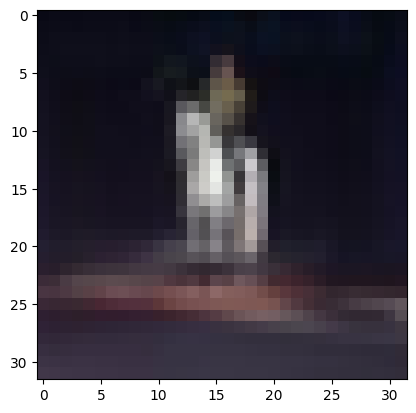

Horse


In [13]:
#showing some pictures from data

def imshow(img):
    img=(img*0.5)+0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0))) #transform the positions
    plt.show()


dataiter = iter(train_cifar_loader)#for creating a iterator at the start of the train loader
images,labels=next(dataiter)#for capturing first batch into images and labels


x=29 #Just a random number for pick
imshow(images[x])#pick the xth image
print(classes_cifar[labels[x]])#write its label

# **Summary Up To Now**
I have loaded the CIFAR images into datasets, converted them into tensors, and normalized them. Then, I created data loaders to shuffle the data and divided it into batches, each containing 128 images. With my testing and training sets prepared, I also implemented a code snippet to display an image and its corresponding label from the training dataset.










In [14]:
# Arrays for flatened images
X_train = []
y_train = []
X_test = []
y_test = []

for data in train_cifar_loader:
    images, labels = data
    X_train.extend(images.numpy())
    y_train.extend(labels.numpy())

for data in test_cifar_loader:
    images, labels = data
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

#converting tensors to NParrays (vectors) due to KNN works with npArrays (vectors)
X_train = np.array(X_train).reshape(len(X_train), -1)
X_test = np.array(X_test).reshape(len(X_test), -1)
y_train = np.array(y_train)
y_test = np.array(y_test)

print("BEFORE [-1, 1] to [0, 1] TRANSFORMATION \n Min: ",X_train[0].min())
print("Max: ", X_train[0].max())
print("Avg: ", X_train[0].mean())
# Convert pixel values from [-1, 1] to [0, 1]
X_train = (np.array(X_train) + 1) / 2
X_test = (np.array(X_test) + 1) / 2

print("AFTER [-1, 1] to [0, 1] TRANSFORMATION \n Min:  ",X_train[0].min())
print("Max: ",X_train[0].max())
print("Avg: ", X_train[0].mean())
print("New shape of training image data: ", X_train.shape) #Hint 32*32*3 = 3072
print("New shape of label data: ", y_train.shape)





BEFORE [-1, 1] to [0, 1] TRANSFORMATION 
 Min:  -0.827451
Max:  0.99215686
Avg:  -0.24712776
AFTER [-1, 1] to [0, 1] TRANSFORMATION 
 Min:   0.086274505
Max:  0.99607843
Avg:  0.37643614
New shape of training image data:  (50000, 3072)
New shape of label data:  (50000,)


In [15]:
#burada kaldım ve burada bir problem var
start_time = time.time()

# Apply feature scaling using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#without scaling k=5 %33 success K=7 %33 K=15 %32

# List of k values to try
k_values = [2,3,5,7,15,50,100,200,250,500]

# Lists to store mean accuracies and standard deviations for each k value
mean_accuracies = []
std_accuracies = []

small_X_train = X_train[:2000]  # For optimization
small_y_train = y_train[:2000]

# Loop over different k values
for k in tqdm(k_values, desc="Processing k_values"):

    knn_classifier = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)

    # Perform cross-validation
    cross_val_scores = cross_val_score(knn_classifier, X_train_scaled, y_train, cv=5)

    # Calculate mean accuracy and standard deviation of accuracy
    mean_accuracy = cross_val_scores.mean()
    std_accuracy = cross_val_scores.std()

    mean_accuracies.append(mean_accuracy)
    std_accuracies.append(std_accuracy)

    print("\nK = ", k ," For test data, Accuracy: ", mean_accuracy, "Standard Deviation: ", std_accuracy)


end_time = time.time()
execution_time = end_time - start_time
print("Execution time: ",execution_time,"seconds")

Processing k_values:  10%|█         | 1/10 [03:17<29:38, 197.57s/it]


K =  2  For test data, Accuracy:  0.30578 Standard Deviation:  0.006324365580831008


Processing k_values:  20%|██        | 2/10 [06:34<26:19, 197.42s/it]


K =  3  For test data, Accuracy:  0.32506 Standard Deviation:  0.0024532427519509867


Processing k_values:  30%|███       | 3/10 [09:46<22:42, 194.66s/it]


K =  5  For test data, Accuracy:  0.33278 Standard Deviation:  0.006256644468083509


Processing k_values:  40%|████      | 4/10 [13:01<19:30, 195.04s/it]


K =  7  For test data, Accuracy:  0.33333999999999997 Standard Deviation:  0.003059150208799827


Processing k_values:  50%|█████     | 5/10 [16:17<16:16, 195.36s/it]


K =  15  For test data, Accuracy:  0.33014 Standard Deviation:  0.0013807244475274613


Processing k_values:  60%|██████    | 6/10 [19:39<13:09, 197.41s/it]


K =  50  For test data, Accuracy:  0.31168 Standard Deviation:  0.004453493011109358


Processing k_values:  70%|███████   | 7/10 [22:57<09:52, 197.62s/it]


K =  100  For test data, Accuracy:  0.29608 Standard Deviation:  0.0023701476747240782


Processing k_values:  80%|████████  | 8/10 [26:15<06:35, 197.91s/it]


K =  200  For test data, Accuracy:  0.28268 Standard Deviation:  0.0022364257197590985


Processing k_values:  90%|█████████ | 9/10 [29:34<03:18, 198.18s/it]


K =  250  For test data, Accuracy:  0.27878 Standard Deviation:  0.0023421357774475867


Processing k_values: 100%|██████████| 10/10 [32:55<00:00, 197.60s/it]


K =  500  For test data, Accuracy:  0.26331999999999994 Standard Deviation:  0.001727888885316417
Execution time:  1980.8525125980377 seconds


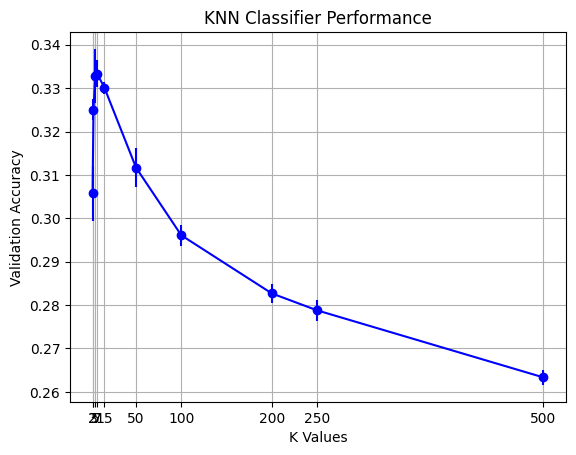

In [16]:
# Plotting the results
plt.errorbar(k_values, mean_accuracies, yerr=std_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('K Values')
plt.ylabel('Validation Accuracy')
plt.title('KNN Classifier Performance')
plt.xticks(k_values)
plt.grid(True)
plt.show()




In [17]:
# Finding the best k value
best_k_index = mean_accuracies.index(max(mean_accuracies))
best_k = k_values[best_k_index]

print(f"Best k value: {best_k}")

# Create the final KNN classifier with the best k value
final_knn_classifier = KNeighborsClassifier(n_neighbors=best_k)

# Perform 5-fold cross-validation on the entire training dataset
cross_val_scores = cross_val_score(final_knn_classifier, X_train_scaled, y_train, cv=5)

# Calculate mean accuracy and standard deviation of accuracy
mean_accuracy = cross_val_scores.mean()
std_accuracy = cross_val_scores.std()

# Train the final model on the entire training dataset
final_knn_classifier.fit(X_train_scaled, y_train)

# Predict labels on test data
y_pred = final_knn_classifier.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy of KNN on test data with best k value: ",accuracy)


Best k value: 7
Accuracy of KNN on test data with best k value:  0.3388


# **Resulting for KNN**


Testing C Values: 100%|██████████| 7/7 [08:58<00:00, 76.96s/it]


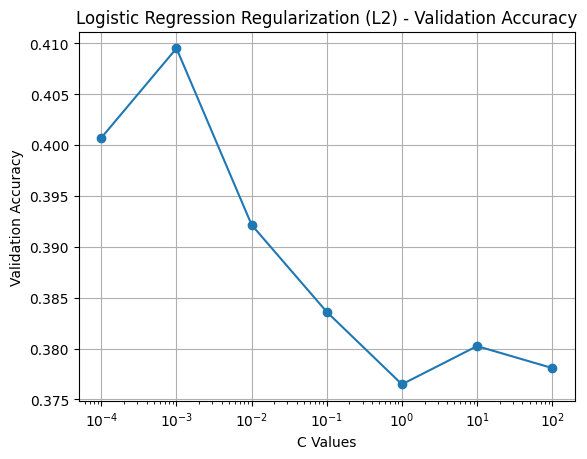

In [18]:



# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


# Apply feature scaling using StandardScaler to X_train and X_val
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# List of C values to try
C_values = [0.0001,0.001, 0.01, 0.1, 1, 10, 100]
warnings.filterwarnings("ignore", category=ConvergenceWarning)#to prevent unwanted warning

# Lists to store accuracy scores for each C value
accuracy_scores = []

# Loop over different C values
for C_value in tqdm(C_values, desc="Testing C Values"):
    # Create a Logistic Regression classifier with L2 regularization and the current C value
    logreg_classifier = LogisticRegression(penalty='l2', C=C_value, max_iter=150, random_state=42)

    # Train the classifier on the training data
    logreg_classifier.fit(X_train_scaled, y_train)

    # Predict labels on the validation data
    y_pred = logreg_classifier.predict(X_val_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

# Plotting the results
plt.plot(C_values, accuracy_scores, marker='o')
plt.xscale('log')  # Use a logarithmic scale for C values
plt.xlabel('C Values')
plt.ylabel('Validation Accuracy')
plt.title('Logistic Regression Regularization (L2) - Validation Accuracy')
plt.grid(True)
plt.show()

In [19]:
# Find the index of the best C value
best_c_index = np.argmax(accuracy_scores)
best_c_value = C_values[best_c_index]

# Train the classifier with the best C value on the entire training data
best_logreg_classifier = LogisticRegression(penalty='l2', C=best_c_value, max_iter=150, random_state=42)
best_logreg_classifier.fit(X_train_scaled, y_train)

# Apply the same feature scaling to X_test
X_test_scaled = scaler.transform(X_test)

# Predict labels on the scaled test data
y_test_pred = best_logreg_classifier.predict(X_test_scaled)


# Calculate accuracy on test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy of Logistic Regression on test data with best C value: ",test_accuracy)

Accuracy of Logistic Regression on test data with best C value:  0.4092


# Resulting for Regression

In [20]:

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes in CIFAR-10

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = x.view(-1, 16 * 16 * 16)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [23]:
# Initialize the CNN
cnn = SimpleCNN()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.01)#lr değeri hyperparameter

# Load CIFAR-10 data using the data loaders
train_cifar_loader = torch.utils.data.DataLoader(train_cifar_dataset, batch_size=128, shuffle=True)
test_cifar_loader = torch.utils.data.DataLoader(test_cifar_dataset, batch_size=128, shuffle=False)

# Train the CNN
#50 epocs:%64.89 test acc
n_epochs = 9

for epoch in range(n_epochs):
    running_loss = 0.0
    correct_total = 0
    total_samples = 0

    for i, (inputs, labels) in enumerate(train_cifar_loader, 0):
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        correct_total += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        if i % 100 == 99:
            avg_loss = running_loss / 100
            accuracy = 100 * correct_total / total_samples
            print(f"Epoch {epoch+1}, Batch {i+1}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
            running_loss = 0.0
            correct_total = 0
            total_samples = 0

print("Training Finished")




Epoch 1, Batch 100, Loss: 1.7731, Accuracy: 36.01%
Epoch 1, Batch 200, Loss: 1.4631, Accuracy: 47.26%
Epoch 1, Batch 300, Loss: 1.3743, Accuracy: 50.68%
Epoch 2, Batch 100, Loss: 1.2213, Accuracy: 56.78%
Epoch 2, Batch 200, Loss: 1.1829, Accuracy: 58.05%
Epoch 2, Batch 300, Loss: 1.1551, Accuracy: 58.84%
Epoch 3, Batch 100, Loss: 1.0679, Accuracy: 62.72%
Epoch 3, Batch 200, Loss: 1.0359, Accuracy: 63.06%
Epoch 3, Batch 300, Loss: 1.0354, Accuracy: 63.79%
Epoch 4, Batch 100, Loss: 0.9348, Accuracy: 67.30%
Epoch 4, Batch 200, Loss: 0.9347, Accuracy: 67.63%
Epoch 4, Batch 300, Loss: 0.9509, Accuracy: 66.84%
Epoch 5, Batch 100, Loss: 0.8466, Accuracy: 70.40%
Epoch 5, Batch 200, Loss: 0.8234, Accuracy: 71.38%
Epoch 5, Batch 300, Loss: 0.8546, Accuracy: 69.77%
Epoch 6, Batch 100, Loss: 0.7636, Accuracy: 73.16%
Epoch 6, Batch 200, Loss: 0.7602, Accuracy: 73.66%
Epoch 6, Batch 300, Loss: 0.7484, Accuracy: 74.05%
Epoch 7, Batch 100, Loss: 0.6538, Accuracy: 77.48%
Epoch 7, Batch 200, Loss: 0.674

In [24]:
# Evaluate the CNN on test data
cnn.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_cifar_loader:
        outputs = cnn(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test data: {100 * correct / total:.2f}%")

Accuracy on test data: 64.73%
